import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from IPython.display import Image 
from io import StringIO
import pydotplus
from sklearn import preprocessing
from sklearn import tree
%matplotlib inline

In [3]:
def convert_yes_no(txt):
    if 'yes' in txt:
        return 1
    else:
        return 0

In [4]:
def plot_decision_tree(clf,feature_name,target_name):
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [5]:
df = pd.read_csv('tennis.csv')

In [6]:
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [7]:
df.windy = df.windy.astype(int)
df.play = df.play.apply(convert_yes_no)

In [8]:
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,0,0
1,sunny,hot,high,1,0
2,overcast,hot,high,0,1
3,rainy,mild,high,0,1
4,rainy,cool,normal,0,1
5,rainy,cool,normal,1,0
6,overcast,cool,normal,1,1
7,sunny,mild,high,0,0
8,sunny,cool,normal,0,1
9,rainy,mild,normal,0,1


In [9]:
df = pd.get_dummies(df)
df

,windy,play,outlook_overcast,outlook_rainy,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal
0,0,0,0,0,1,0,1,0,1,0
1,1,0,0,0,1,0,1,0,1,0
2,0,1,1,0,0,0,1,0,1,0
3,0,1,0,1,0,0,0,1,1,0
4,0,1,0,1,0,1,0,0,0,1
5,1,0,0,1,0,1,0,0,0,1
6,1,1,1,0,0,1,0,0,0,1
7,0,0,0,0,1,0,0,1,1,0
8,0,1,0,0,1,1,0,0,0,1
9,0,1,0,1,0,0,0,1,0,1


In [10]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [11]:
X_train = df.loc[:, df.columns != 'play']

In [12]:
Y_train = df.play
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [13]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [17]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [18]:
clf = clf.fit(X_train,Y_train)

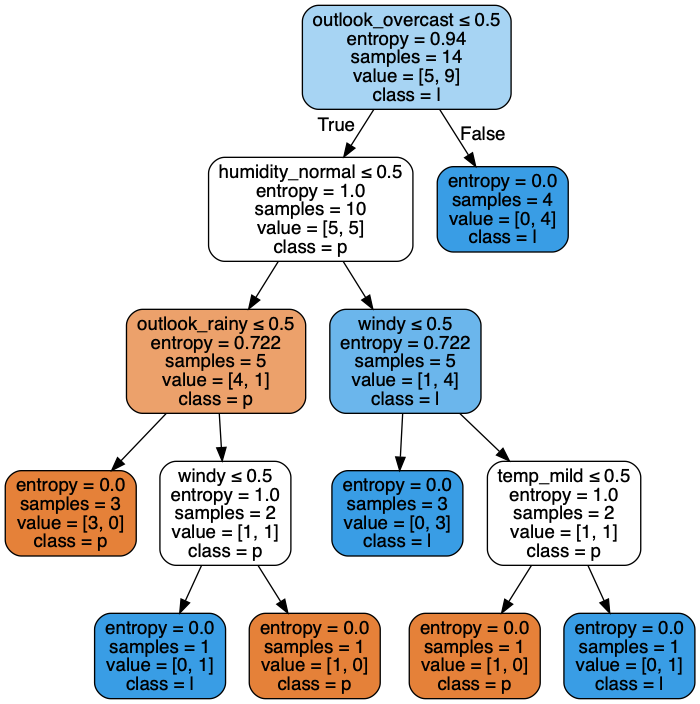

In [19]:
plot_decision_tree(clf, X_train.columns,df.columns[1])